Length of train_dataset:  60000
Length of test_dataset:  10000
train_dataset[0]:  (<PIL.Image.Image image mode=L size=28x28 at 0x1AD8377D0D0>, 5)
Label:  5


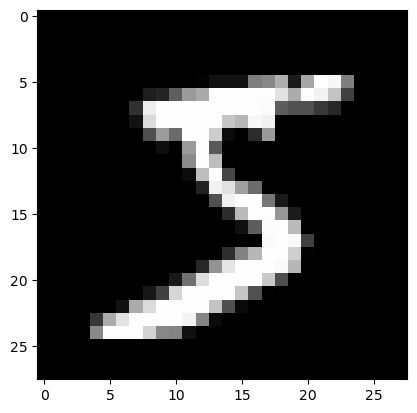

In [54]:
#IMAGE CLASSIFICATION USING LOGISTIC REGRESSION - 1/2

import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline

#Download training dataset
train_dataset = MNIST(root='data/', download=True)
print("Length of train_dataset: ", len(train_dataset))

#Download test dataset
test_dataset = MNIST(root='data/', train=False)
print("Length of test_dataset: ", len(test_dataset))

print("train_dataset[0]: ",train_dataset[0])

image, label = train_dataset[0]
plt.imshow(image, cmap='gray')
print("Label: ", label)


In [1]:
#IMAGE CLASSIFICATION USING LOGISTIC REGRESSION IN CPU - 2/2


import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline

dataset = MNIST(root='data/', train = True, transform = transforms.ToTensor())

img_tensor , label = dataset[0]
print(img_tensor.shape, label)


print(img_tensor[:, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
print("len(train_ds): ", len(train_ds), ", len(val_ds): ", len(val_ds) )

#Prepare dataloaders
from torch.utils.data import DataLoader
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

import torch.nn as nn
import torch.nn.functional as F

input_size = 28 * 28
num_classes = 10

#Logistic regression model
model = nn.Linear(input_size, num_classes)



def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()



def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader,val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        #Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history



result0 = evaluate(model, val_loader)
result0

history1 = fit(5, 0.001, model, train_loader,val_loader)
history2 = fit(5, 0.001, model, train_loader,val_loader)
history3 = fit(5, 0.001, model, train_loader,val_loader)
history4 = fit(5, 0.001, model, train_loader,val_loader)

history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs # of epochs')

#Define test data
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())


def predict_image(img, model):
    xb = img.unsqueeze(0)  #this changes img size from 1x28x28 to 1x1x28x28
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

#Select a random test data (that is image and label) and then predict that
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label: ', label, ' , Predicted: ', predict_image(img, model))

test_loader = DataLoader(test_dataset, batch_size = 256)
result = evaluate(model, test_loader)
result

d:\ProgramData\anaconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


torch.Size([1, 28, 28]) 5
tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)
len(train_ds):  50000 , len(val_ds):  10000
Epoch [0], val_loss: 1.9548, val_acc: 0.6074
Epoch [1], val_loss: 1.6843, val_acc: 0.7237
Epoch [2], val_loss: 1.4821, val_acc: 0.7631
Epoch [3], val_loss: 1.3294, val_acc: 0.7855
Epoch [4], val_loss: 1.2121, val_acc: 0.7995
Epoch [0], val_loss: 1.1198, val_acc: 0.8098
Epoch [1], val_loss: 1.0458, val_acc: 0.8175
Epoch [2], val_loss: 0.9853, val_acc: 0.8231
Epoch [3], val_loss: 0.9350, val_acc: 0.8275
Epoch [4], val_loss: 0.8924, val_acc: 0.8324
Epoch [0], val_loss: 0.8560, val_acc: 0.8369
Epoch [1], val_loss: 0.8244, val_acc: 0.8397
Epoch [2], val_loss: 0.7969, val_acc: 0.8426
